## Загрузим нужные библиотеки

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [108]:
df = pd.read_csv("train_dataset_train.csv")

<ipython-input-108-2918eab5658b>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train_dataset_train.csv")


## Рассмотрим датасет по ближе

In [5]:
df.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [7]:
df["label"].value_counts()

0    5829020
1     170980
Name: label, dtype: int64

Рассмотрим часть столбцов типа "object"

In [8]:
df["is_in_yandex"].value_counts()

N    3585956
Y    2411374
0       2670
Name: is_in_yandex, dtype: int64

In [9]:
df["is_return"].value_counts()

N    5993017
Y       6983
Name: is_return, dtype: int64

In [52]:
df.groupby(['is_in_yandex'])['label'].agg(['mean', 'count'])

,mean,count
is_in_yandex,,
0,0.000000,2670
1,0.031919,3585956
2,0.023439,2411374


In [51]:
df['label'].value_counts()

0    5829020
1     170980
Name: label, dtype: int64

Эти категории можно сделать ранговыми 

In [10]:
df["is_in_yandex"] = pd.Categorical(df["is_in_yandex"])
df["is_in_yandex"].astype('category').cat.codes
df["is_in_yandex"] = df["is_in_yandex"].cat.codes

In [11]:
df["is_return"] = pd.Categorical(df["is_return"])
df["is_return"].astype('category').cat.codes
df["is_return"] = df["is_return"].cat.codes

Посмотрим на некоторые столбцы

<AxesSubplot:xlabel='class', ylabel='count'>

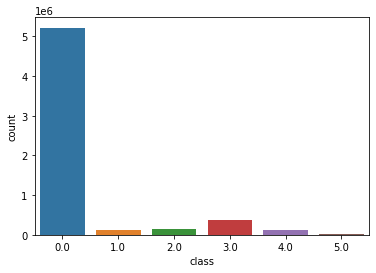

In [12]:
sns.countplot(x = "class" , data  = df) 

In [17]:
df.groupby(['type'])['label'].agg(['mean', 'count'])

,mean,count
type,,
0,0.018293,3444
АО,0.248466,1304
АОПП,0.000000,6682
ГОПС,0.105354,463750
ММПО,0.067704,1614974
МРП,0.000000,3850
МСО,0.000402,7465
МСЦ,0.000148,223241
ОП,0.000105,9527


In [18]:
sns.countplot(x = "weight" , data  = df) 

<AxesSubplot:xlabel='weight', ylabel='count'>

Error in callback <function flush_figures at 0x7f60dcf13820> (for post_execute):


KeyboardInterrupt: 

Псотроим матрицу корреляции значений

In [19]:
plt.rcParams['figure.figsize']=(15,15)


corr = df.iloc[:100000].corr()
g = sns.heatmap(corr, square = True, annot=True)

KeyboardInterrupt: 

## Выделим выборки

In [53]:
df = df.fillna(0)

Обьединим список не нужных строк с списком строк типа object

In [109]:
df['index_oper'] = df['index_oper'].replace(' ', 0).astype(float)

In [110]:
col_obj = df.select_dtypes(include=['object']).columns.values
col_obj = list(set(col_obj) ^ set(["id", "label"]))

In [112]:
col_obj

['type',
 'is_return',
 'oper_type + oper_attr',
 'name_mfi',
 'id',
 'label',
 'is_privatecategory',
 'is_in_yandex']

In [113]:
from sklearn.preprocessing import LabelEncoder

In [114]:
encs = {}
for col in col_obj:
    if col == 'label':
        continue
    enc = LabelEncoder()
    df[col + '_enc'] = enc.fit_transform(df[col])
    encs[col] = enc

In [115]:
X = df.drop(col_obj, axis = 1)
y = df[["label"]]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [117]:
import lightgbm as lgb
import catboost as cb

In [124]:
clf = lgb.LGBMClassifier(num_leaves=127)

In [125]:
clf.fit(X_train, y_train, eval_set=(X_test, y_test))

/home/dro/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[1]	valid_0's binary_logloss: 0.0815176
[2]	valid_0's binary_logloss: 0.0740219
[3]	valid_0's binary_logloss: 0.0686062
[4]	valid_0's binary_logloss: 0.0642872
[5]	valid_0's binary_logloss: 0.060727
[6]	valid_0's binary_logloss: 0.0577654
[7]	valid_0's binary_logloss: 0.0552776
[8]	valid_0's binary_logloss: 0.0531545
[9]	valid_0's binary_logloss: 0.0513082
[10]	valid_0's binary_logloss: 0.0497215
[11]	valid_0's binary_logloss: 0.0483178
[12]	valid_0's binary_logloss: 0.0470988
[13]	valid_0's binary_logloss: 0.0460278
[14]	valid_0's binary_logloss: 0.0450793
[15]	valid_0's binary_logloss: 0.0442457
[16]	valid_0's binary_logloss: 0.0435074
[17]	valid_0's binary_logloss: 0.0428464
[18]	valid_0's binary_logloss: 0.0422653
[19]	valid_0's binary_logloss: 0.0417638
[20]	valid_0's binary_logloss: 0.0412993
[21]	valid_0's binary_logloss: 0.0408723
[22]	valid_0's binary_logloss: 0.0404988
[23]	valid_0's binary_logloss: 0.0401676
[24]	valid_0's binary_logloss: 0.039878
[25]	valid_0's binary_loglo

LGBMClassifier(num_leaves=127)

## Оценка точности

In [126]:
pred = clf.predict(X_test)

In [127]:
from sklearn.metrics import recall_score, roc_auc_score

score = recall_score(y_test, pred, average = "macro" )
auc = roc_auc_score(y_test, pred)

In [128]:
print("Recall", score)

Recall 0.8042337300996198


In [129]:
print('auc', auc)

auc 0.80423373009962
